### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

### Reading data

In [2]:
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/train.csv')

In [3]:
train_df.shape,test_df.shape,train_df.columns

((9557, 143),
 (9557, 143),
 Index(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q',
        'v18q1', 'r4h1',
        ...
        'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
        'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq', 'Target'],
       dtype='object', length=143))

#### The data has 143 columns and 9557 rows in train and test data

#### The output variable is the column the Target column

In [4]:
train_df['Target'].value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

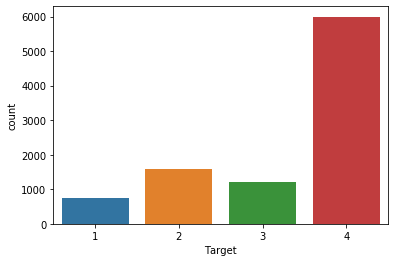

In [5]:
sns.countplot(train_df['Target'])

### The target is a multi class variable with 1-4 values. The data is imbalanced with target class 4 having more data.

In [6]:
# Non numeric columns include
train_df.select_dtypes(exclude=np.number).columns

Index(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], dtype='object')

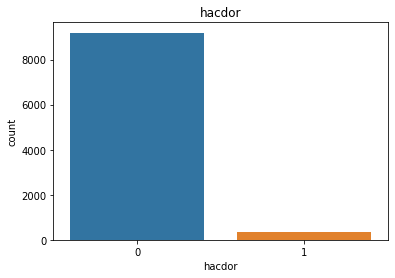

C:\Users\ajayd\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """


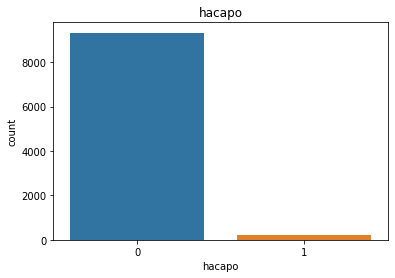

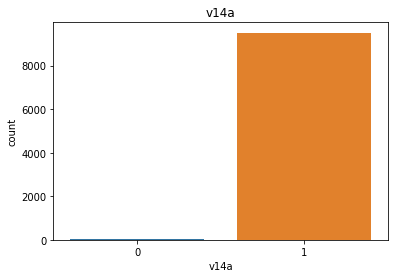

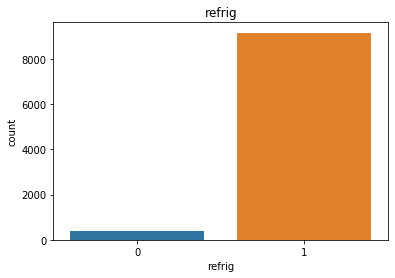

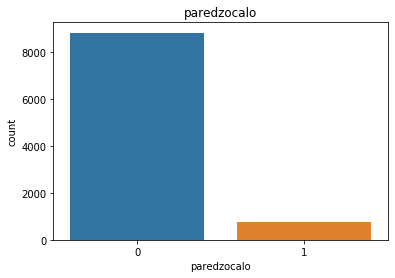

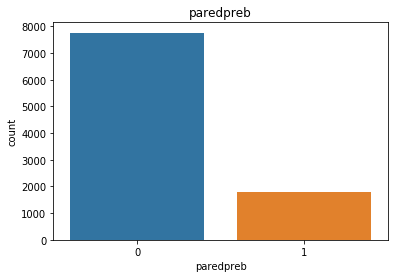

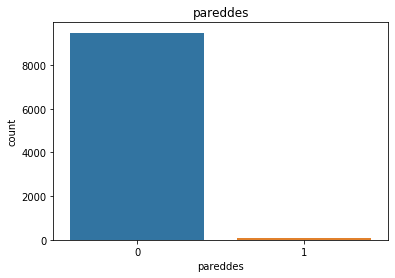

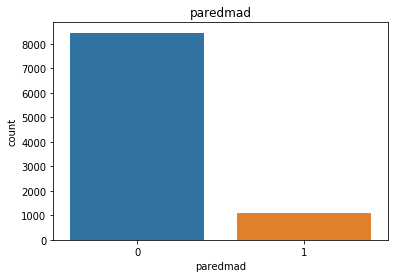

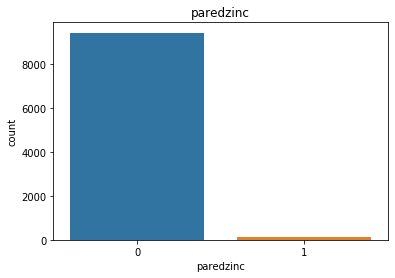

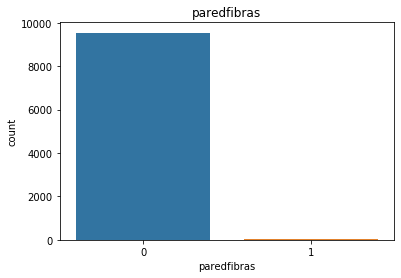

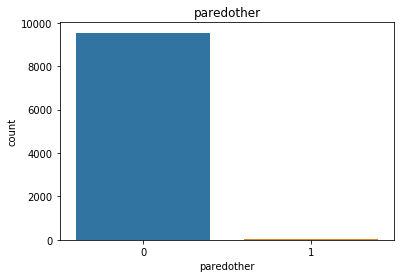

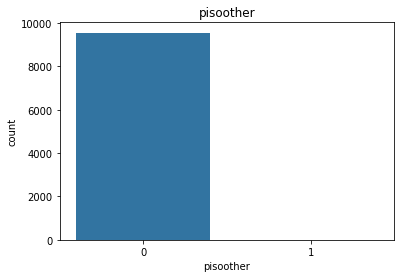

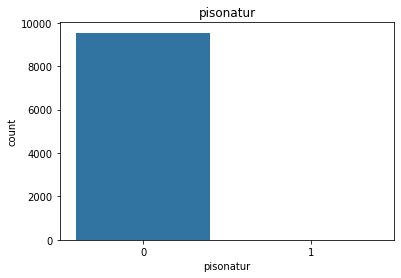

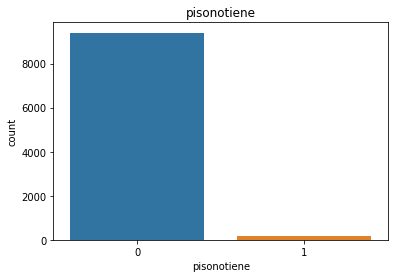

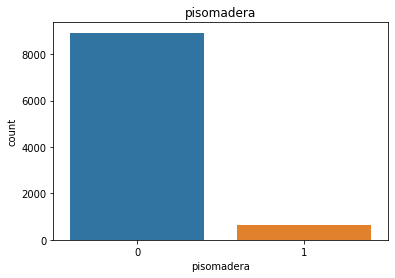

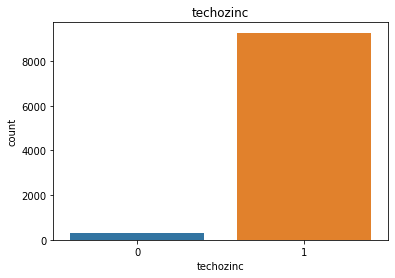

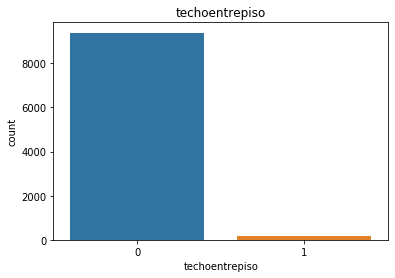

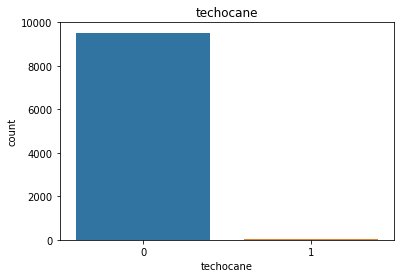

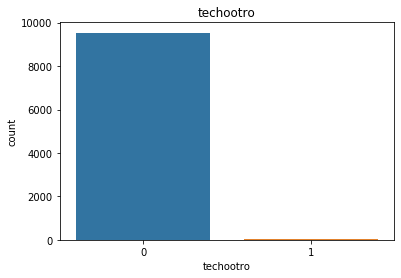

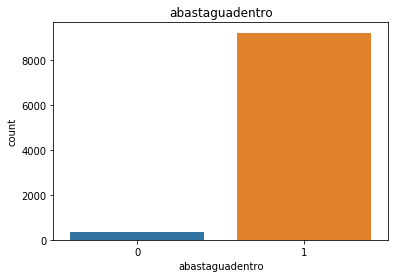

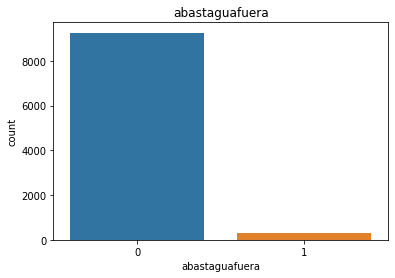

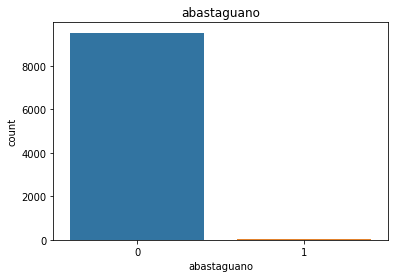

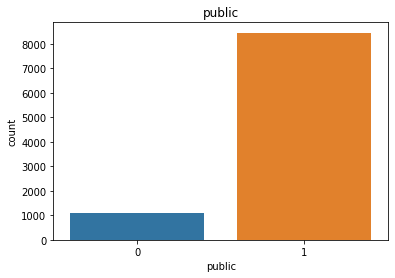

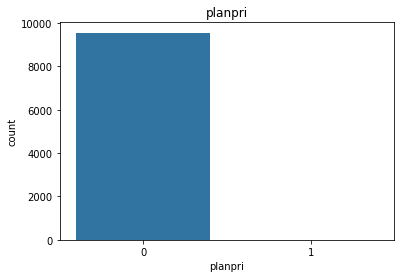

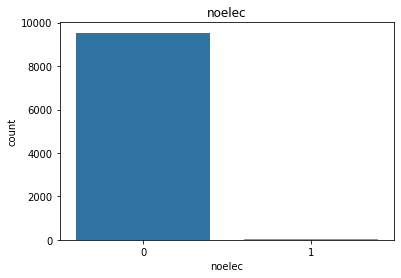

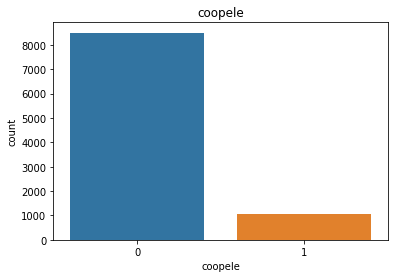

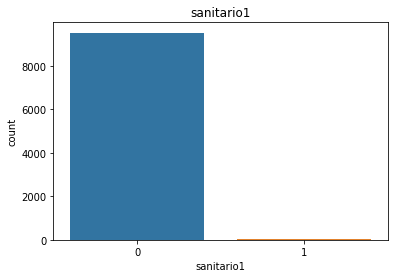

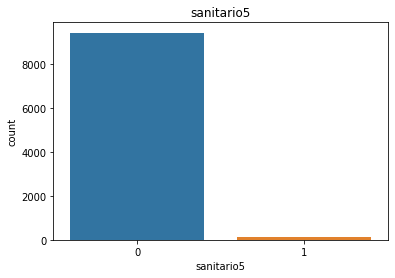

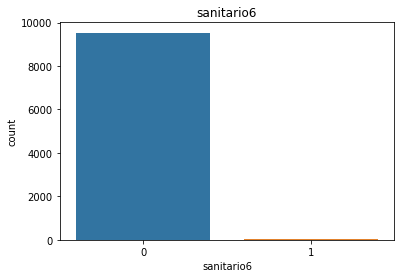

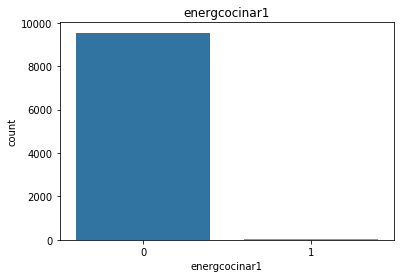

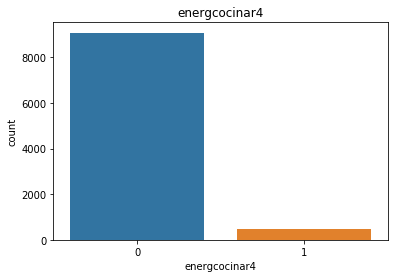

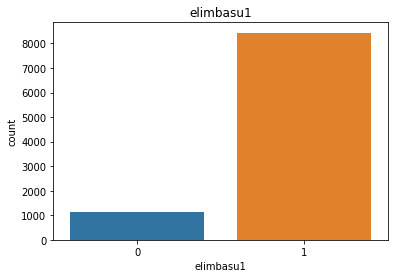

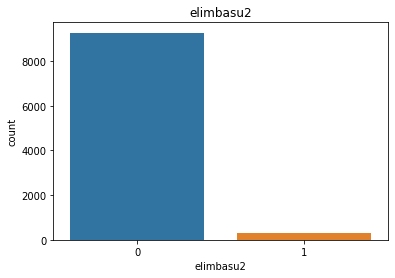

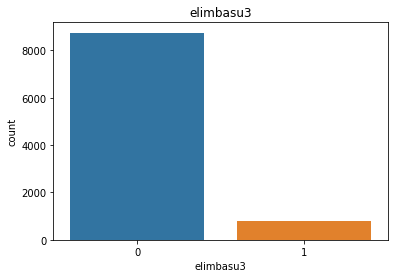

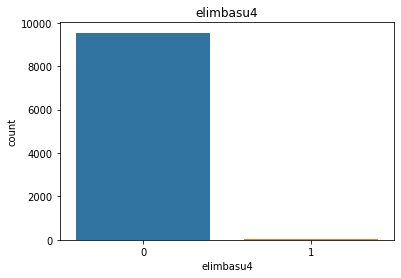

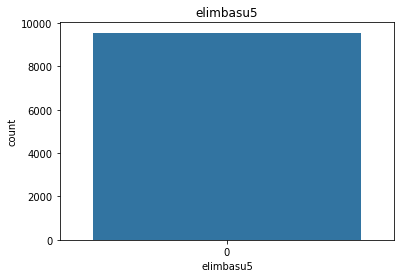

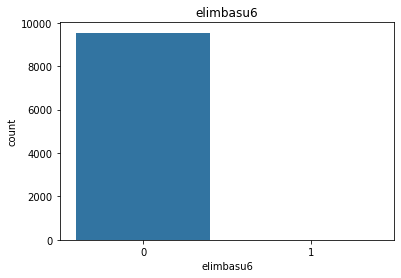

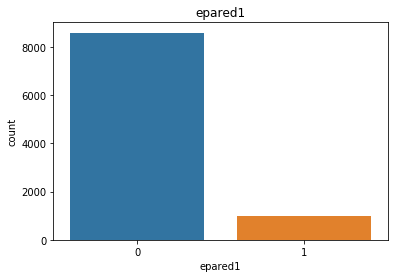

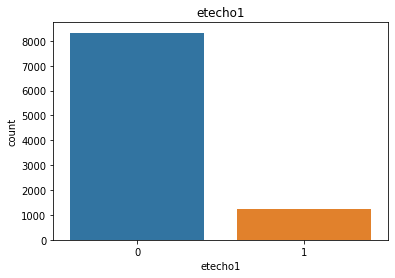

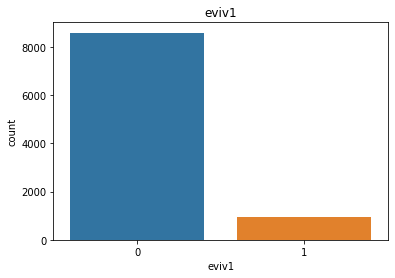

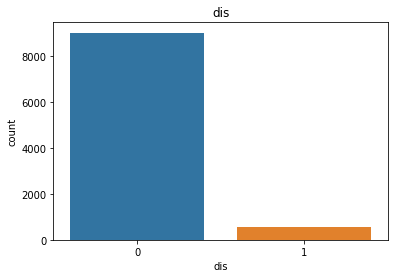

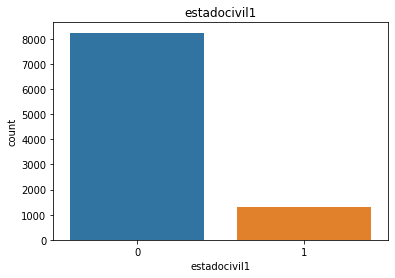

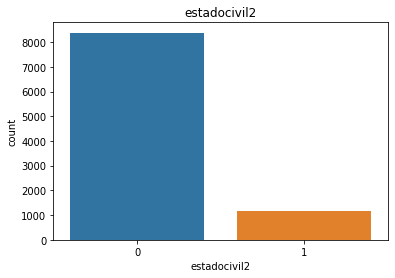

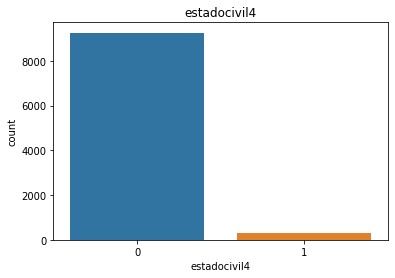

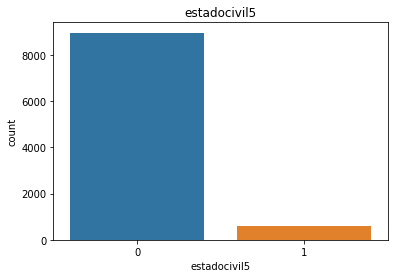

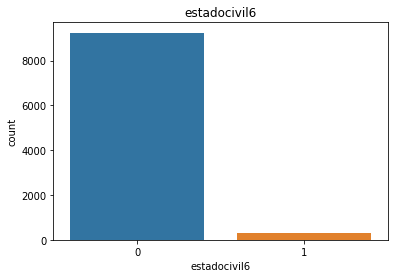

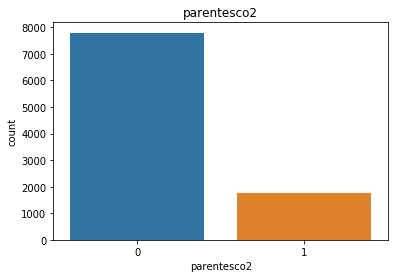

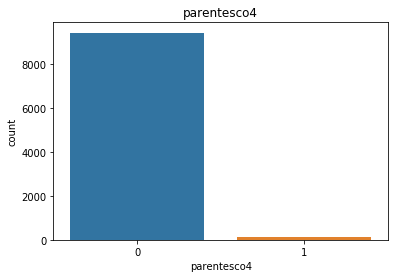

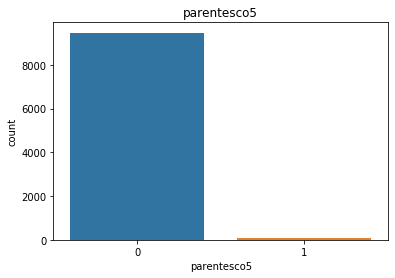

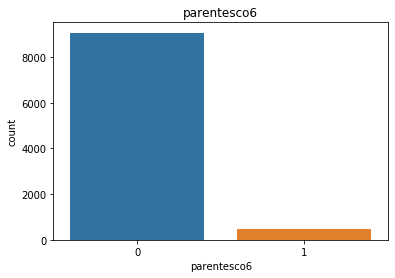

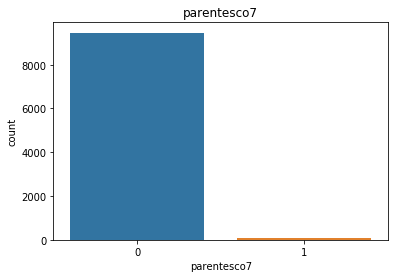

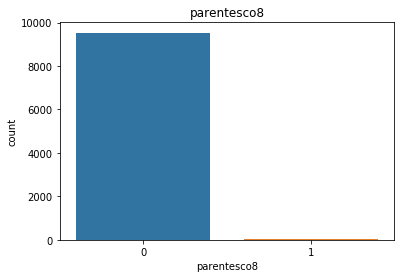

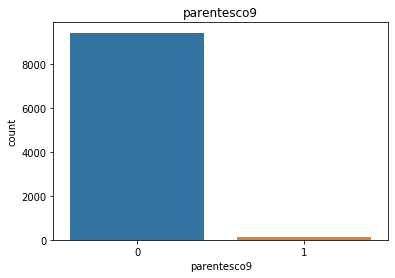

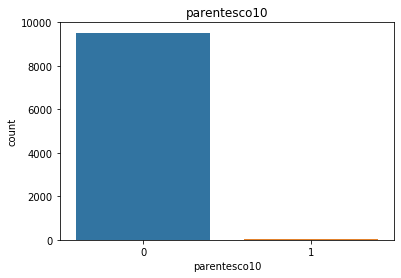

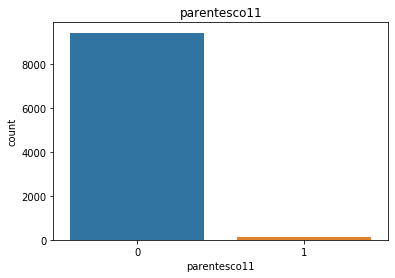

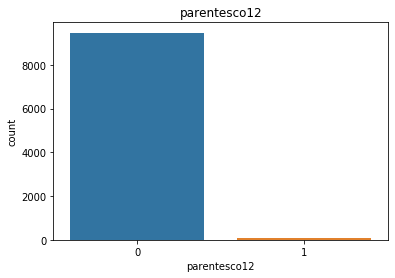

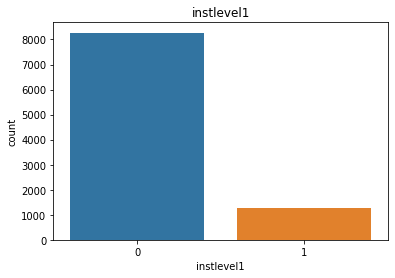

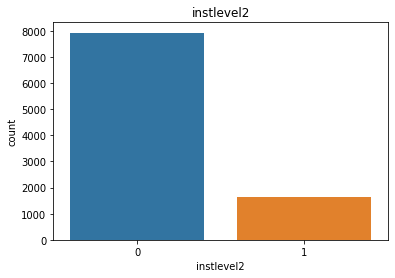

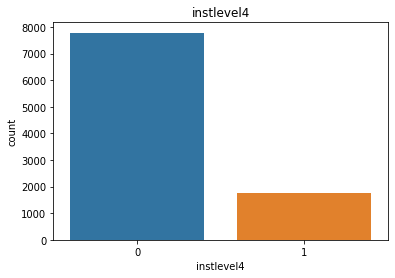

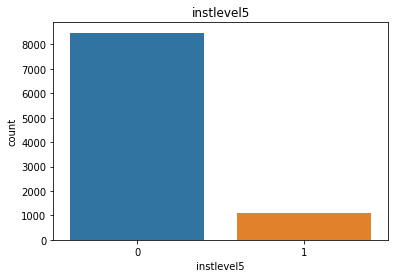

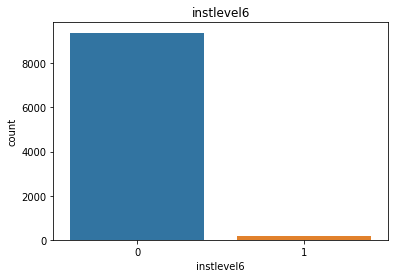

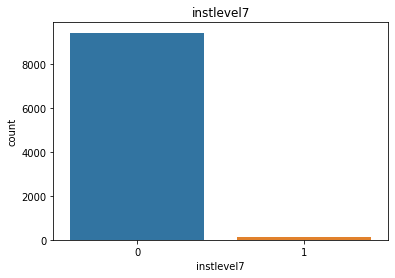

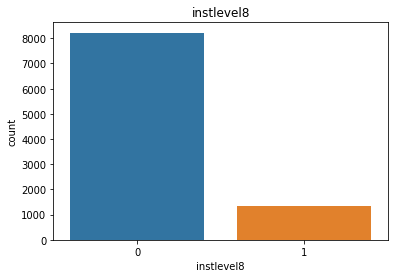

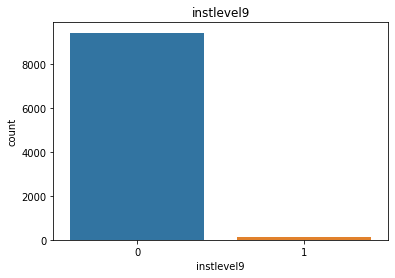

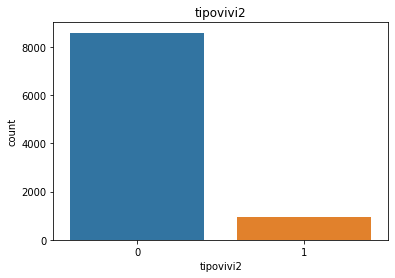

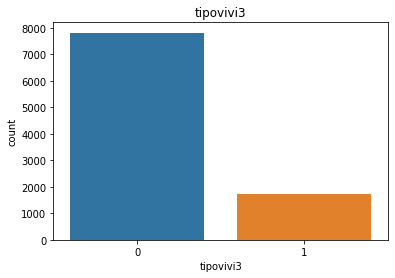

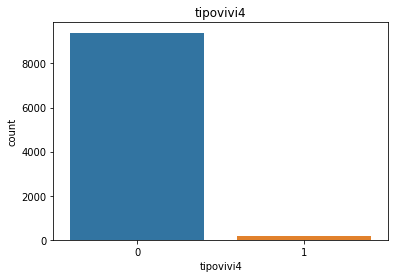

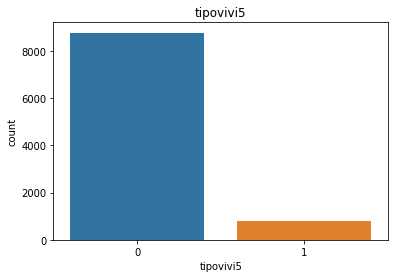

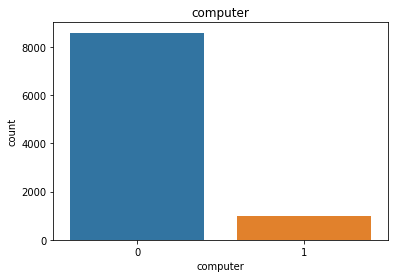

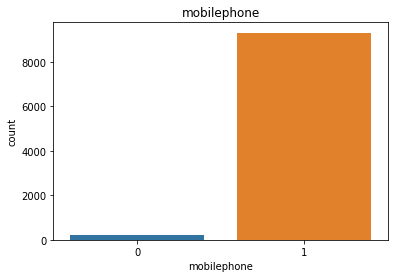

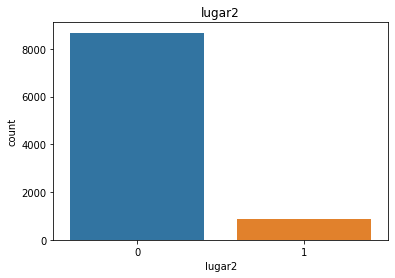

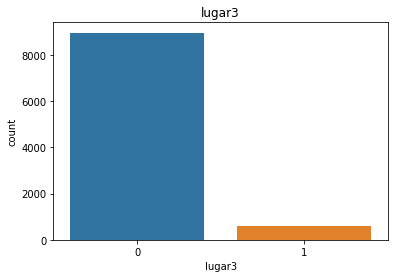

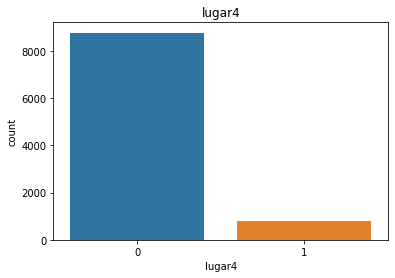

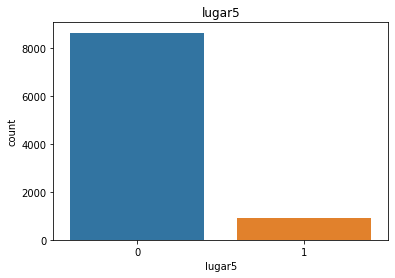

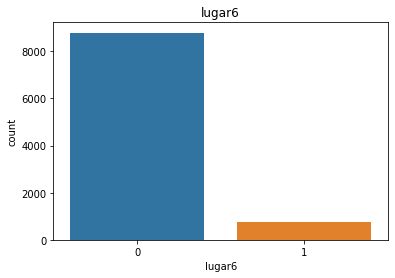

In [7]:
biased_columns = []
for index,value in train_df.select_dtypes(include=np.int64).iteritems():
    bins = np.bincount(value)
    bins = bins/bins.sum()
    if bins[bins >0.8]:
        biased_columns.append(index)
        sns.countplot(value)
        plt.title(f'{index}')
        plt.show()

In [8]:
# These 75 columns have bias
biased_columns

['hacdor',
 'hacapo',
 'v14a',
 'refrig',
 'paredzocalo',
 'paredpreb',
 'pareddes',
 'paredmad',
 'paredzinc',
 'paredfibras',
 'paredother',
 'pisoother',
 'pisonatur',
 'pisonotiene',
 'pisomadera',
 'techozinc',
 'techoentrepiso',
 'techocane',
 'techootro',
 'abastaguadentro',
 'abastaguafuera',
 'abastaguano',
 'public',
 'planpri',
 'noelec',
 'coopele',
 'sanitario1',
 'sanitario5',
 'sanitario6',
 'energcocinar1',
 'energcocinar4',
 'elimbasu1',
 'elimbasu2',
 'elimbasu3',
 'elimbasu4',
 'elimbasu5',
 'elimbasu6',
 'epared1',
 'etecho1',
 'eviv1',
 'dis',
 'estadocivil1',
 'estadocivil2',
 'estadocivil4',
 'estadocivil5',
 'estadocivil6',
 'parentesco2',
 'parentesco4',
 'parentesco5',
 'parentesco6',
 'parentesco7',
 'parentesco8',
 'parentesco9',
 'parentesco10',
 'parentesco11',
 'parentesco12',
 'instlevel1',
 'instlevel2',
 'instlevel4',
 'instlevel5',
 'instlevel6',
 'instlevel7',
 'instlevel8',
 'instlevel9',
 'tipovivi2',
 'tipovivi3',
 'tipovivi4',
 'tipovivi5',
 'com

In [9]:
households_where_pov_diff = []

for group,group_df in train_df.groupby('idhogar'):
    if group_df.Target.unique().size > 1:
        households_where_pov_diff.append(group)

In [10]:
# Number of house holds where the poverty levels vary within a single household
len(households_where_pov_diff)

85

In [11]:
# Number of households without head in cases where mismatch of poverty levels happened
train_df[train_df.idhogar.isin(households_where_pov_diff)].groupby('idhogar').apply(lambda x: 1 not in x.parentesco1.unique()).sum()

0

In [12]:
# Correcting poverty levels for households with mismatch in the values
for household in households_where_pov_diff:
    household_pov_val = train_df.loc[np.logical_and(train_df['idhogar'] == household,train_df['parentesco1'] == 1),'Target'].iloc[0]
    train_df.loc[train_df['idhogar'] == household,'Target'] = household_pov_val    

In [13]:
train_df = train_df.drop(columns = biased_columns)
test_df= test_df.drop(columns = biased_columns)

In [14]:
temp = train_df.isnull().sum()
temp[temp>0].sort_values(ascending=False)

rez_esc      7928
v18q1        7342
v2a1         6860
SQBmeaned       5
meaneduc        5
dtype: int64

In [15]:
# Columns rez_esc, v18q1, v2a1, SQBmeaned, meaneduc have null values, but the 5 missing values in SQBmeaned and meaneduc can be imputed. 
# Drop columns rez_esc, v18q1, v2a1 as they contain very less information
null_columns = ['rez_esc', 'v18q1', 'v2a1']
train_df = train_df.drop(columns = null_columns)
test_df = test_df.drop(columns = null_columns)

In [16]:
# All columns with discrete integer values are non null
train_df.select_dtypes(include=np.int64).isnull().sum().any()

False

In [17]:
# Columns with continuous values having missing count are
train_df.select_dtypes(include=np.float64).isnull().sum()

meaneduc           5
overcrowding       0
SQBovercrowding    0
SQBdependency      0
SQBmeaned          5
dtype: int64

In [18]:
# To see the null values in continuous data columns. We can see null values for both columns occur on the same rows
train_df[train_df['meaneduc'].isna()][['meaneduc','SQBmeaned']]

,meaneduc,SQBmeaned
1291,NaN,NaN
1840,NaN,NaN
1841,NaN,NaN
2049,NaN,NaN
2050,NaN,NaN


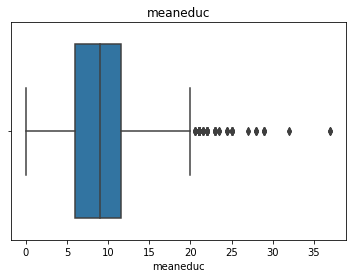

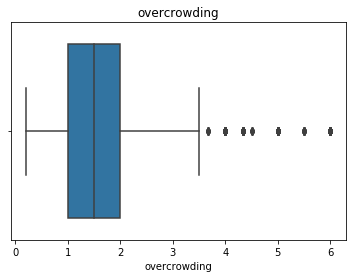

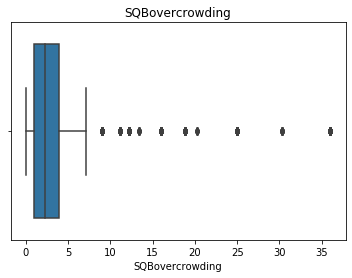

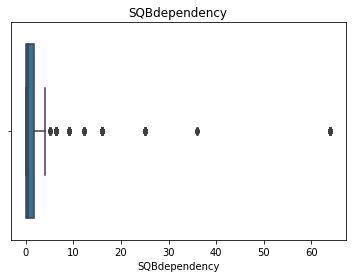

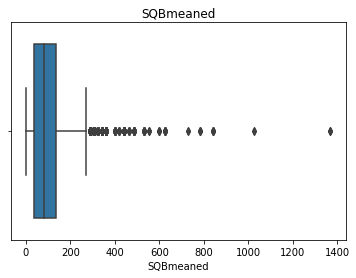

In [19]:
# To select impute strategy for meaneduc,SQBmeaned
for index,value in train_df.select_dtypes(include=np.float64).iteritems():
    sns.boxplot(value)
    plt.title(index)
    plt.show()

In [20]:
for index,values in train_df[['meaneduc','SQBmeaned']].iteritems():
    value = values.dropna()
    quantiles = np.quantile(value,[0.25,0.75])
    print(np.where((value >= 1.5 * quantiles[0]) & (value <= 1.5 *quantiles[1]))[0].shape,value.shape)

(4531,) (9552,)
(4984,) (9552,)


In [21]:
# The box plot shows meaneduc,SQBmeaned have too many outliers (around 50%). The outliers must therefore not be a data entry error and can not be removed.
# Using median imputing will remove the effect of outliers on the data which might be significant. So we chose mean imputing
train_df['meaneduc'] = train_df['meaneduc'].fillna(train_df['meaneduc'].mean())
train_df['SQBmeaned'] = train_df['SQBmeaned'].fillna(train_df['SQBmeaned'].mean())

In [22]:
# See for outliers in continuous data
for index,value in train_df.select_dtypes(include=np.float64).iteritems():
    quantiles = np.quantile(value,[0.25,0.75])
    print(index)
    print(np.where((value >= 1.5 * quantiles[0]) & (value <= 1.5 *quantiles[1]))[0].shape,value.shape)
    print()

meaneduc
(4528,) (9557,)

overcrowding
(4590,) (9557,)

SQBovercrowding
(5277,) (9557,)

SQBdependency
(5149,) (9557,)

SQBmeaned
(4983,) (9557,)



#### All the continuous variables have too many outliers. 
#### These columns can not be discarded as they can not be due to data entry error and may add meaning to data

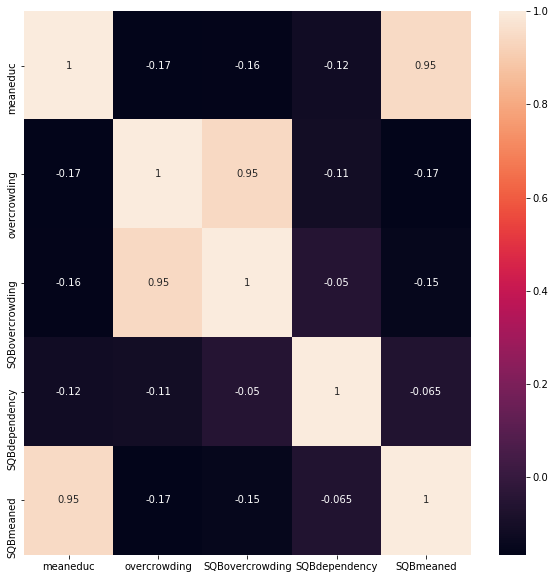

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df.select_dtypes(include=np.float64).corr(),annot=True)

#### Columns meaneduc and SQBmeaned are highly correlated. Columns overcrowding and SQBovercrowding are highly correlated 
#### meaneduc and overcrowding can be chosen and the other two can be dropped

In [24]:
# Dropping columns SQBmeaned and SQBovercrowding as they are highly correlated with other independent variables

train_df = train_df.drop(columns=['SQBmeaned','SQBovercrowding'])

In [25]:
# setting Id column as index instead of dropping it as non numeric/ non categorical data
train_df = train_df.set_index('Id')
for index,value in train_df.select_dtypes(exclude=np.number).iteritems():
    print(index)
    print(np.unique(value))
    print()
    # Replace yes with 1 and no with 0
    try:
        train_df[index] = train_df[index].replace({'no':'0','yes':'1'}).apply(float)
    except:
        train_df = train_df.drop(columns=[index])

idhogar
['001ff74ca' '003123ec2' '004616164' ... 'ffae4a097' 'ffe90d46f'
 'fff7d6be1']

dependency
['.16666667' '.2' '.22222222' '.25' '.2857143' '.33333334' '.40000001'
 '.5' '.60000002' '.66666669' '.71428573' '.75' '.80000001' '.83333331'
 '1.2' '1.25' '1.3333334' '1.5' '1.6666666' '1.75' '2' '2.25' '2.5' '3'
 '3.5' '4' '5' '6' '8' 'no' 'yes']

edjefe
['10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '3' '4'
 '5' '6' '7' '8' '9' 'no' 'yes']

edjefa
['10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '3' '4'
 '5' '6' '7' '8' '9' 'no' 'yes']



In [26]:
train_df.columns

Index(['rooms', 'v18q', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1',
       'r4t2', 'r4t3', 'tamhog', 'tamviv', 'escolari', 'hhsize', 'paredblolad',
       'pisomoscer', 'pisocemento', 'cielorazo', 'sanitario2', 'sanitario3',
       'energcocinar2', 'energcocinar3', 'epared2', 'epared3', 'etecho2',
       'etecho3', 'eviv2', 'eviv3', 'male', 'female', 'estadocivil3',
       'estadocivil7', 'parentesco1', 'parentesco3', 'hogar_nin', 'hogar_adul',
       'hogar_mayor', 'hogar_total', 'dependency', 'edjefe', 'edjefa',
       'meaneduc', 'instlevel3', 'bedrooms', 'overcrowding', 'tipovivi1',
       'television', 'qmobilephone', 'lugar1', 'area1', 'area2', 'age',
       'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
       'SQBdependency', 'agesq', 'Target'],
      dtype='object')

In [27]:
X_train, Y_train = train_df.drop(columns = 'Target'), train_df['Target']

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)
train_df_standardized = scaler.transform(X_train)

In [29]:
classifier = RandomForestClassifier(n_estimators=300, n_jobs=-1, verbose=1, max_depth = 8, min_samples_leaf = 5, random_state=12345)

In [30]:
classifier.fit(X_train,Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=12345,
                       verbose=1, warm_start=False)

In [31]:
# Train accuracy
classifier.score(X_train,Y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished


0.7631055770639322

### Follow the same preprocessing steps and scaling steps for the test dataset

In [32]:
# Drop columns which were dropped from train dataset

test_df['meaneduc'] = test_df['meaneduc'].fillna(test_df['meaneduc'].mean())
test_df['SQBmeaned'] = test_df['SQBmeaned'].fillna(test_df['SQBmeaned'].mean())
drop_columns = biased_columns + null_columns + ['SQBmeaned','SQBovercrowding']
test_df = test_df.drop(columns = drop_columns,errors='ignore')

In [33]:
test_df = test_df.set_index('Id')
for index,value in test_df.select_dtypes(exclude=np.number).iteritems():
    print(index)
    print(np.unique(value))
    print()
    # Replace yes with 1 and no with 0 and drops idhogar
    try:
        test_df[index] = test_df[index].replace({'no':'0','yes':'1'}).apply(float)
    except:
        test_df = test_df.drop(columns=[index])

idhogar
['001ff74ca' '003123ec2' '004616164' ... 'ffae4a097' 'ffe90d46f'
 'fff7d6be1']

dependency
['.16666667' '.2' '.22222222' '.25' '.2857143' '.33333334' '.40000001'
 '.5' '.60000002' '.66666669' '.71428573' '.75' '.80000001' '.83333331'
 '1.2' '1.25' '1.3333334' '1.5' '1.6666666' '1.75' '2' '2.25' '2.5' '3'
 '3.5' '4' '5' '6' '8' 'no' 'yes']

edjefe
['10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '3' '4'
 '5' '6' '7' '8' '9' 'no' 'yes']

edjefa
['10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '3' '4'
 '5' '6' '7' '8' '9' 'no' 'yes']



In [34]:
X_test, Y_test = test_df.drop(columns = 'Target'), test_df['Target']
test_df_standardized = scaler.transform(X_test)

In [35]:
y_pred = classifier.predict(X_test)
classifier.score(X_test, Y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished


0.7554671968190855

In [36]:
print(classification_report(Y_test,y_pred))
print()
print(confusion_matrix(Y_test,y_pred))

              precision    recall  f1-score   support

           1       0.86      0.37      0.52       755
           2       0.70      0.49      0.58      1597
           3       0.95      0.19      0.32      1209
           4       0.75      0.99      0.85      5996

    accuracy                           0.76      9557
   macro avg       0.82      0.51      0.57      9557
weighted avg       0.78      0.76      0.71      9557


[[ 281  115    2  357]
 [  35  780   11  771]
 [   5  146  235  823]
 [   5   67    0 5924]]


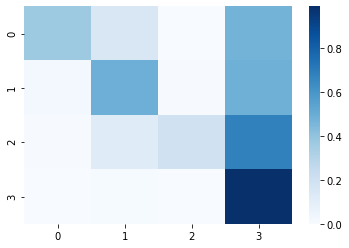

In [37]:
sns.heatmap(confusion_matrix(Y_test,y_pred,normalize='true'),cmap='Blues')
plt.show()

In [38]:
accuracy = cross_val_score(classifier,X_test, Y_test,scoring='accuracy',cv=10).mean()*100

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend L

In [39]:
print(accuracy)

65.51239895726084


#### The model achieved a 65% accuracy score

In [40]:
from sklearn import tree

In [42]:
tree.plot_tree(classifier.estimators_[0])

[Text(158.18017241379312, 205.35999999999999, 'X[16] <= 0.5\ngini = 0.553\nsamples = 6025\nvalue = [785, 1556, 1182, 6034]'),
 Text(88.1094827586207, 181.2, 'X[57] <= 6.5\ngini = 0.709\nsamples = 1827\nvalue = [448, 810, 482, 1175]'),
 Text(43.934482758620696, 157.04, 'X[48] <= 1.5\ngini = 0.664\nsamples = 1324\nvalue = [265, 456, 335, 1048]'),
 Text(18.6, 132.88, 'X[6] <= 0.5\ngini = 0.731\nsamples = 281\nvalue = [112, 150, 65, 122]'),
 Text(8.337931034482759, 108.72, 'X[42] <= 7.25\ngini = 0.451\nsamples = 46\nvalue = [7, 12, 2, 53]'),
 Text(5.131034482758621, 84.56, 'X[45] <= 0.583\ngini = 0.62\nsamples = 27\nvalue = [7, 11, 2, 23]'),
 Text(2.5655172413793106, 60.400000000000006, 'X[43] <= 0.5\ngini = 0.472\nsamples = 12\nvalue = [6, 1, 0, 14]'),
 Text(1.2827586206896553, 36.24000000000001, 'gini = 0.198\nsamples = 5\nvalue = [1, 0, 0, 8]'),
 Text(3.8482758620689657, 36.24000000000001, 'gini = 0.569\nsamples = 7\nvalue = [5, 1, 0, 6]'),
 Text(7.696551724137931, 60.400000000000006, '

Error in callback <function flush_figures at 0x0000020686963318> (for post_execute):


KeyboardInterrupt: 

In [45]:
import pydotplus
import six
from sklearn import tree
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in classifier.estimators_:
    if (i_tree <1):        
        tree.export_graphviz(tree_in_forest, out_file=dotfile)
        pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png('dtree'+ str(i_tree) +'.png')
        i_tree = i_tree + 1